<a href="https://colab.research.google.com/github/Jingxuan99/-Python-2-/blob/master/2_accomodation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install POT

     |████████████████████████████████| 656 kB 4.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import pylab as pl  # do the plots
import ot
import time

import warnings
warnings.simplefilter("ignore", UserWarning)

# Data we use

In [ ]:
# Campus and accommodations name
PG_accomm = ["Ascham Court", "Buccleuch Place",
             "Deaconess House", "Holland Annexe",
             "O'Shea Hall", "Pentland House",
             "Ratcliffe Terrace","Richmond Place",
             "West Mains Road"]

# campus = ["Kings Buildings", "Easter Bush", "Little France",
#           "George Square", "College of Art", "New College",
#           "Old College", "Moray House"]

main_campus = ["Kings Buildings","George Square","Easter Bush"]


# Accommodations and campuses capacity
bp = 6*5*12; ac = 15*6; ph = 300 # Assume 300 in Pentland House (website: 300 bikes)
accomm_capacity = [ac, 136+bp, 280+35, 20,
                   (407+41+6*2)+249+(469+7*2),
                   ph, 70+14, 280, 123]
total_amount = sum(accomm_capacity)
campus_capacity = np.array((0.3,0.6,0.1))*total_amount

In [ ]:
# campus_info see this as bakeries
from geopy.geocoders import Nominatim
geolocator = Nominatim()

campus_info = pd.DataFrame(columns=['Campus','Latitude','Longitude'])

for i in range(len(main_campus)):
  campus_info.loc[i] = [main_campus[i],
                        geolocator.geocode("Edinburgh "+main_campus[i]).latitude,
                        geolocator.geocode("Edinburgh "+main_campus[i]).longitude
                        ]

# accomm_info see this as cafes
accomm_info = pd.DataFrame(columns=['Accommodation','Latitude','Longitude'])
for i in range(len(PG_accomm)):
  accomm_info.loc[i] = [PG_accomm[i],
                        geolocator.geocode("Edinburgh "+PG_accomm[i]).latitude,
                        geolocator.geocode("Edinburgh "+PG_accomm[i]).longitude
                        ]

In [ ]:
# Combine the information together
accomm_info['Capacity'] = accomm_capacity
campus_info['Capacity'] = campus_capacity
display(campus_info)
display(accomm_info)

,Campus,Latitude,Longitude,Capacity
0,Kings Buildings,55.924458,-3.173428,870.0
1,George Square,55.943438,-3.190257,1740.0
2,Easter Bush,55.860205,-3.206555,290.0


,Accommodation,Latitude,Longitude,Capacity
0,Ascham Court,55.941756,-3.184960,90
1,Buccleuch Place,55.942535,-3.188230,496
2,Deaconess House,55.945329,-3.181276,315
3,Holland Annexe,55.937707,-3.170542,20
4,O'Shea Hall,55.949144,-3.180430,1192
5,Pentland House,55.930015,-3.247907,300
6,Ratcliffe Terrace,55.933561,-3.177999,84
7,Richmond Place,55.946398,-3.183289,280
8,West Mains Road,55.924403,-3.172447,123


# Draw the map to see the data we got

In [ ]:
# from numpy.core.fromnumeric import size
# https://www.zhihu.com/question/33783546
# https://python-visualization.github.io/folium/modules.html

import folium

# Create map of Edinburgh and display it
edin_map = folium.Map(location=[55.910324, -3.205219], zoom_start=11, width=400, height=400)

# Instantiate a feature group for the incidents in the dataframe
incidents_campus = folium.map.FeatureGroup(name='Campuses')
incidents_accomm = folium.map.FeatureGroup(name='Accommodation')

# Loop through the campus and accommodation locations and add each to the incidents feature group
for name, lat, lng,r in zip(campus_info.Campus, campus_info.Latitude, campus_info.Longitude,campus_info.Capacity):
  incidents_campus.add_child(
      folium.CircleMarker(
          [lat, lng],
          radius=r/100, # define how big you want the circle markers to be
          color='red',
          fill=True,
          fill_color='red',
          fill_opacity=0.4))
  # folium.Marker([lat, lng], popup=name).add_to(edin_map)
  
for name, lat, lng, r in zip(accomm_info.Accommodation, accomm_info.Latitude, accomm_info.Longitude,accomm_info.Capacity):
  incidents_accomm.add_child(
      folium.CircleMarker(
          [lat, lng],
          radius=r/100, # define how big you want the circle markers to be
          color='blue',
          fill=True,
          fill_color='blue',
          fill_opacity=0.4))
  # folium.Marker([lat, lng], popup=name).add_to(edin_map)

# Add incidents to map
edin_map.add_child(incidents_campus) #red
edin_map.add_child(incidents_accomm) #blue

edin_map.add_child(folium.LayerControl())

from branca.element import Figure
edin_fig = Figure(width=400, height=400)
edin_fig.add_child(edin_map)
edin_fig

# Optimal transport

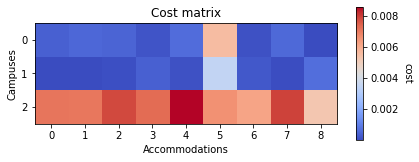

In [ ]:
# Compute cost matrix (Euclidean distance)
C = ot.dist(campus_info[['Latitude','Longitude']].values,
            accomm_info[['Latitude','Longitude']].values)

# Plot cost matrix
im = pl.imshow(C, cmap="coolwarm")
cbar = pl.colorbar(im, shrink=0.5, use_gridspec=True)
cbar.ax.set_ylabel("cost", rotation=-90, va="bottom")
pl.title('Cost matrix')
pl.xlabel('Accommodations')
pl.ylabel('Campuses')
pl.tight_layout()

## EMD

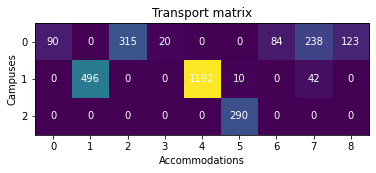

In [ ]:
# Solving the OT problem with ot.emd (Earth Movers distance problem)
start = time.time()
ot_emd = ot.emd(np.array(campus_info.Capacity),
                np.array(accomm_info.Capacity), C)
time_emd = time.time() - start

# Plot the matrix
im = pl.imshow(ot_emd)
for i in range(len(np.array(campus_info.Capacity))):
    for j in range(len(np.array(accomm_info.Capacity))):
        text = pl.text(j, i, '{0:g}'.format(ot_emd[i, j]),
                       ha="center", va="center", color="w")
pl.title('Transport matrix')
pl.xlabel('Accommodations')
pl.ylabel('Campuses')
pl.show()

The transport matrix gives the number of students that can be allocated from each campus to each accommodation.

In [ ]:
# Transportation plan vizualization
# bakeries = campus, cafes= accommodation
new_map = folium.Map(location=[55.910324, -3.205219],
                     zoom_start=11, width=400, height=400) # Create a new map
for i in range(3):
  for j in range(9):
    # Plot the lines
    folium.PolyLine(
        locations = [(campus_info.Latitude[i],campus_info.Longitude[i]),
                     (accomm_info.Latitude[j],accomm_info.Longitude[j])],
                    weight = ot_emd[i,j]/200,color = 'red').add_to(new_map)

new_map.add_child(incidents_campus) #red
new_map.add_child(incidents_accomm) #blue
new_map.add_child(folium.LayerControl())
new_fig = Figure(width=400, height=400)
new_fig.add_child(new_map)
new_fig

In [ ]:
# OT loss
W = np.sum(ot_emd * C)
print('Wasserstein loss (EMD) = {0:.2f}'.format(W))

Wasserstein loss (EMD) = 2.45


## Sinkhorn

In [ ]:
# Compute Sinkhorn transport matrix
reg = 0.1
ot_sinkhorn = ot.sinkhorn(np.array(campus_info.Capacity),
                          np.array(accomm_info.Capacity),
                          reg=reg, M=C/C.max())

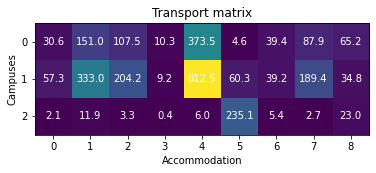

In [ ]:
# Plot the transport matrix sloved by Sinkhorn
im = pl.imshow(ot_sinkhorn)
for i in range(len(np.array(campus_info.Capacity))):
    for j in range(len(np.array(accomm_info.Capacity))):
        text = pl.text(j, i, np.round(ot_sinkhorn[i, j], 1),
                       ha="center", va="center", color="w")
pl.title('Transport matrix')
pl.xlabel('Accommodation')
pl.ylabel('Campuses')
pl.show()

Not sparse at all with Sinkhorn.

Each campus alocate students to all 9 accommodations with this solution.

Also, this solution gives a transport with fractions, which does not make sense in the case of croissants. 

This was not the case with EMD.

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:485: RuntimeWarning: overflow encountered in true_divide
  u = 1. / nx.dot(Kp, v)


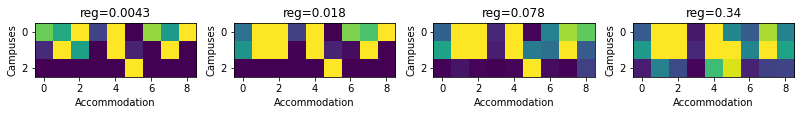

In [ ]:
# Varying the regularization parameter in Sinkhorn
reg_parameter = np.logspace(-3, 0, 20)
W_sinkhorn_reg = np.zeros((len(reg_parameter), ))
time_sinkhorn_reg = np.zeros((len(reg_parameter), ))

f = pl.figure(5, (14, 5))
max_ot = 100  # plot matrices with the same colorbar
for k in range(len(reg_parameter)):
    start = time.time()
    ot_sinkhorn = ot.sinkhorn(np.array(campus_info.Capacity),
                              np.array(accomm_info.Capacity),
                              reg=reg_parameter[k], M=C/C.max())
    time_sinkhorn_reg[k] = time.time() - start

    if k % 4 == 0 and k > 0:  # we only plot a few
        ax = pl.subplot(1, 5, k // 4)
        im = pl.imshow(ot_sinkhorn, vmin=0, vmax=max_ot)
        pl.title('reg={0:.2g}'.format(reg_parameter[k]))
        pl.xlabel('Accommodation')
        pl.ylabel('Campuses')

    # Compute the Wasserstein loss for Sinkhorn, and compare with EMD
    W_sinkhorn_reg[k] = np.sum(ot_sinkhorn * C)
    
pl.tight_layout()
pl.show()

The solution of Sinkhorn starts with something very similar to EMD (although not sparse)

for very small values of the regularization parameter, 

Tends to a more uniform solution as the regularization parameter increases.

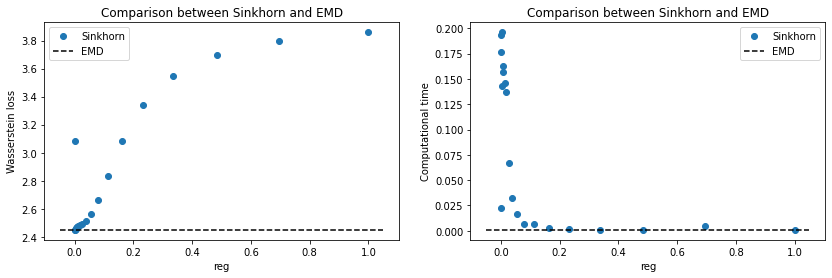

In [ ]:
# Wasserstein loss
f = pl.figure(2, (14, 4))
ax = pl.subplot(1,2,1)
pl.title("Comparison between Sinkhorn and EMD")
pl.plot(reg_parameter, W_sinkhorn_reg, 'o', label="Sinkhorn")
XLim = pl.xlim()
pl.plot(XLim, [W, W], '--k', label="EMD")
pl.legend()
pl.xlabel("reg")
pl.ylabel("Wasserstein loss")

# Computational time
ax = pl.subplot(1,2,2)
pl.title("Comparison between Sinkhorn and EMD")
pl.plot(reg_parameter, time_sinkhorn_reg, 'o', label="Sinkhorn")
XLim = pl.xlim()
pl.plot(XLim, [time_emd, time_emd], '--k', label="EMD")
pl.legend()
pl.xlabel("reg")
pl.ylabel("Computational time")

pl.show()